# Multiclass Classification of Stack Overflow Questions

In [2]:
# Importing necessary libraries and modules for the project

import tensorflow as tf
import os
import re
import string

### Load the dataset

In [3]:
train_dataset=tf.keras.utils.text_dataset_from_directory(
    '/Users/krupalitejani/Desktop/DL/stack_overflow_16k/train',
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=42
)

val_dataset=tf.keras.utils.text_dataset_from_directory(
    '/Users/krupalitejani/Desktop/DL/stack_overflow_16k/train',
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=42
)

test_dataset=tf.keras.utils.text_dataset_from_directory(
    '/Users/krupalitejani/Desktop/DL/stack_overflow_16k/test',
    batch_size=32
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [4]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):  # Display 3 examples
        print(f"Text: {text_batch[i].numpy()}")
        print(f"Label: {label_batch[i].numpy()}")

Text: b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default construc

2025-01-21 21:56:20.441946: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Preparing the dataset for training 

#### Standardization

In [5]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

#### Tokenization & Vectorization

In [6]:
from tensorflow.keras.layers import TextVectorization

max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [7]:
train_text = train_dataset.map(lambda x, y: x)

##This step adapts the TextVectorization layer to the train_text dataset, 
##learning the vocabulary from the training data. This ensures that the 
##vectorizer understands the most frequent words in your dataset and can 
##correctly tokenize and encode the text.
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


train_ds = train_dataset.map(vectorize_text)
val_ds = val_dataset.map(vectorize_text)
test_ds = test_dataset.map(vectorize_text)


2025-01-21 21:56:20.837931: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# Code for preprocessing, utility, or specific task
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating Model

In [54]:
# Importing necessary libraries and modules for the project
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Embedding,GlobalAveragePooling1D
from tensorflow.keras import regularizers


In [106]:
model=Sequential()

model.add(Embedding(max_features,16))  ##input and output----convert interger coded words to vectors
model.add(Dropout(0.2))
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(4,activation='softmax'))


In [58]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Compiling the model

In [108]:
from tensorflow.keras import losses

model.compile(optimizer='adam',loss=losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

### Early Stopping

In [100]:
# Importing necessary libraries and modules for the project
from tensorflow.keras.callbacks import EarlyStopping 

early_stop=EarlyStopping(monitor='val_loss', 
                         mode='max',                                        
                         verbose=1,
                        restore_best_weights=True)

### Train the model & Plotting accuracy and loss over time

In [64]:
# Code for preprocessing, utility, or specific task
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(model_his.history['accuracy'], label='Training Accuracy')
    plt.plot(model_his.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(model_his.history['loss'], label='Training Loss')
    plt.plot(model_his.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3026 - loss: 1.5320 - val_accuracy: 0.3581 - val_loss: 1.4129
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3590 - loss: 1.3961 - val_accuracy: 0.4425 - val_loss: 1.3496
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4168 - loss: 1.3300 - val_accuracy: 0.4387 - val_loss: 1.2431
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4673 - loss: 1.2246 - val_accuracy: 0.5556 - val_loss: 1.1393
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5403 - loss: 1.1320 - val_accuracy: 0.6450 - val_loss: 1.0528
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.6046 - loss: 1.0526 - val_accuracy: 0.6756 - val_loss: 0.9831
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.6382 - loss: 0.9843 - val_accuracy: 0.6925 - val_loss: 0.9301
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.6498 - loss: 0.9360 - val_accura

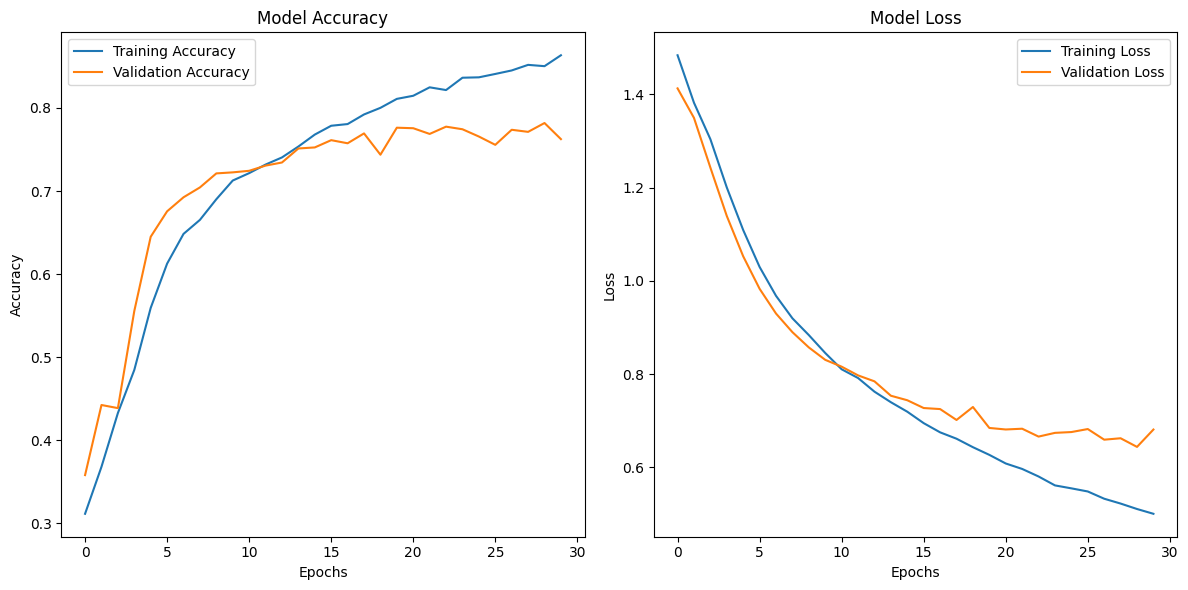

In [110]:
# Training the model
# Providing training and validation datasets, and specifying the number of epochs
model_his=model.fit(train_ds,validation_data=val_ds,epochs=30)
plot_metrics(model_his)

### Evaluating the model

In [112]:
# Evaluating the model performance on the test dataset
loss,accuracy=model.evaluate(test_ds)

print("Loss:" ,loss)
print("Accuracy:" ,accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.7431 - loss: 0.7286
Loss: 0.7332815527915955
Accuracy: 0.737500011920929


### Classification Report and Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/

2025-01-21 21:58:30.252987: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


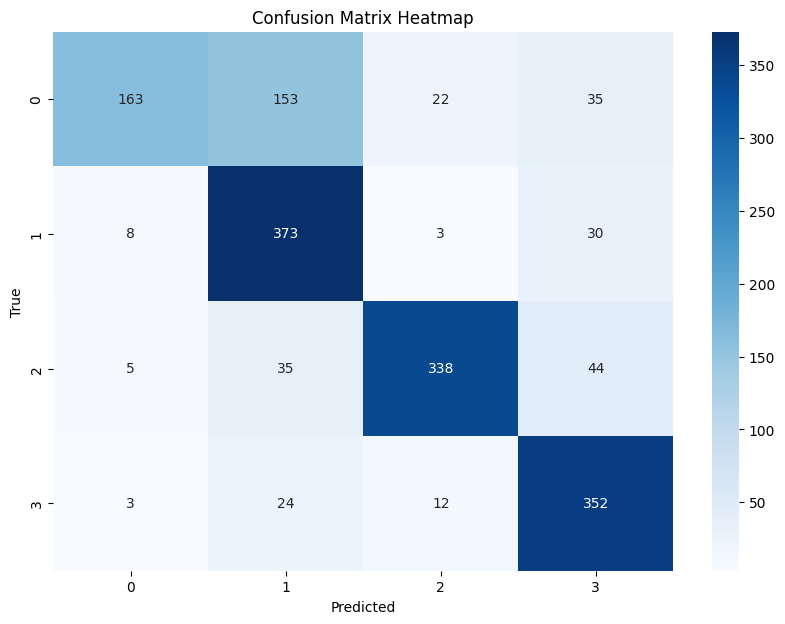

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Evaluation after predictions
def evaluate_model(model, test_ds):
    y_true = []
    y_pred = []

    for x_batch, y_batch in test_ds:
        predictions = model.predict(x_batch)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(y_batch.numpy())

    print("Classification Report:\n", classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()
    

evaluate_model(model, val_ds)